# Challenge Intermedio 2 — Spark ML con Visualizaciones (v2)

Este notebook guía el desarrollo completo de un pipeline de **clasificación** en **Spark ML**, con **EDA** y **gráficas** obligatorias.


## Objetivos
1. Cargar un dataset público (recomendado: *Wine Quality* UCI) con Spark.
2. Realizar **EDA** con gráficos (histogramas, boxplots, correlación, distribución de la etiqueta).
3. Construir un **pipeline** (VectorAssembler + StandardScaler) y entrenar **al menos dos modelos** (LR, RF).
4. Evaluar con métricas y **gráficas** (ROC, PR, matriz de confusión, importancia de variables).
5. Realizar **búsqueda de hiperparámetros** con **CrossValidator**.


## Requisitos técnicos
- Spark 3.4+ con PySpark.
- Para graficar, usar `matplotlib` (una figura por gráfico, **sin** estilos o colores específicos).
- Para graficar desde Spark, convertir a pandas con `toPandas()` cuando sea necesario.


In [1]:
# === 1) Setup de Spark ===
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("wine-quality-ml-v2")
    # .config("spark.driver.memory", "4g")  # opcional
    .getOrCreate()
)

spark


## Carga del dataset

> Usa el conjunto **Wine Quality** (red o white) del UCI Repository. Ajusta la ruta al CSV.


In [2]:
# === 2) Carga de datos ===
# Ajusta la ruta al archivo CSV (usa el separador ';' del dataset original)
# Ejemplo: path = "/dbfs/FileStore/winequality-red.csv" o path local si corres fuera de Databricks.
path = "data/winequality-red.csv"  # <-- CAMBIA ESTA RUTA
raw = spark.read.csv(path, header=True, inferSchema=True, sep=';')
raw.printSchema()
raw.show(5)

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|          

## Ingeniería de características y etiqueta binaria

Creamos `label = 1` si `quality >= 6`, de lo contrario `0`. (Puedes justificar otro umbral).


In [3]:
# === 3) Ingeniería de características y etiqueta ===
from pyspark.sql import functions as F

wine = raw.withColumn("label", (F.col("quality") >= 6).cast("int"))
wine.select("quality", "label").groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  855|
|    0|  744|
+-----+-----+



## EDA — Gráficas obligatorias

Para graficar, convertimos a pandas con `toPandas()`.
- Histogramas por variable numérica
- Boxplots
- Matriz de correlación
- Distribución de la etiqueta


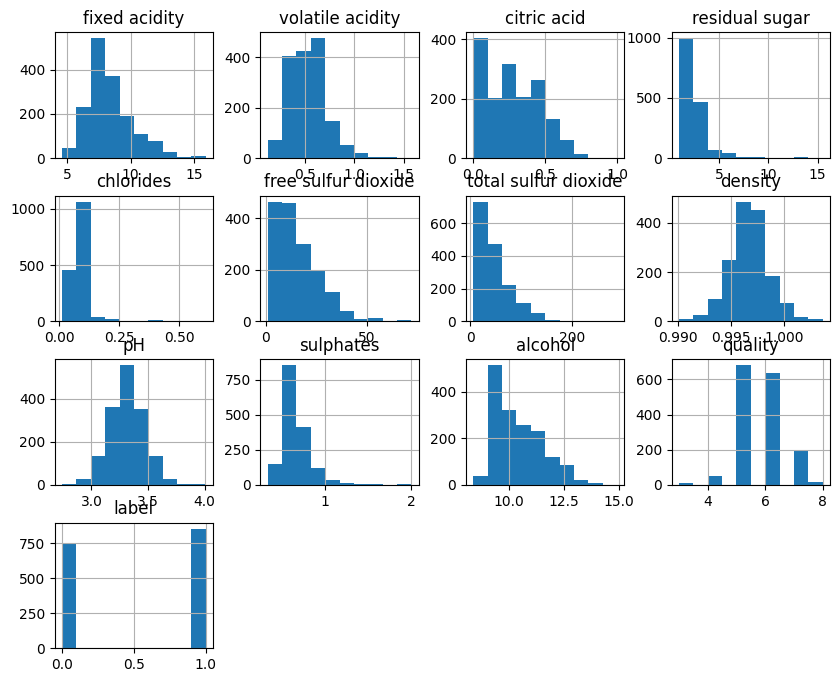

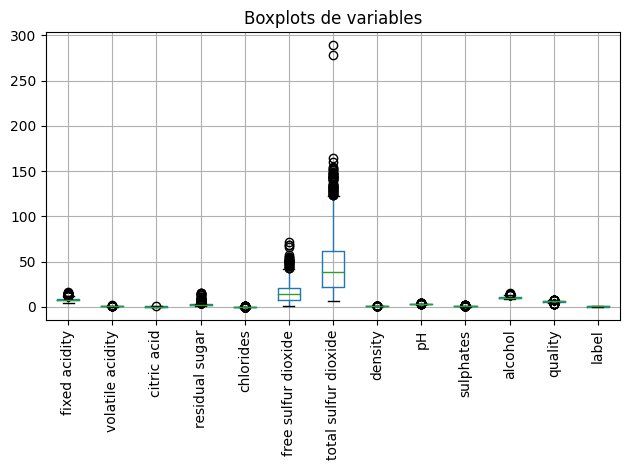

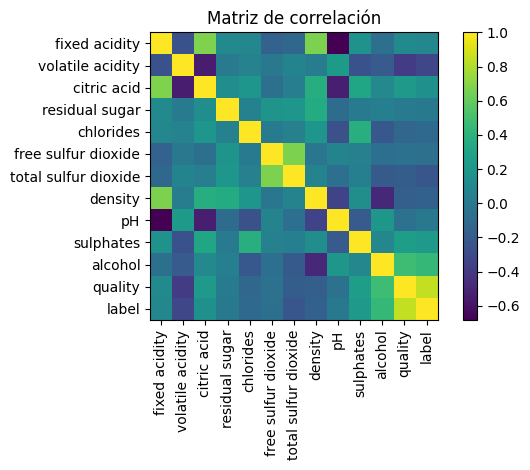

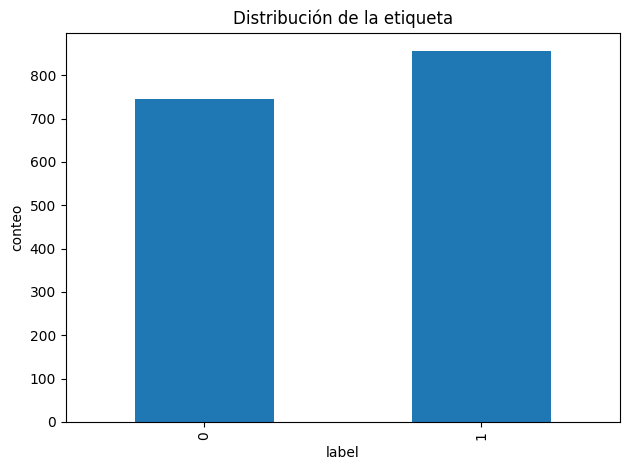

In [4]:
# === 4) EDA: Histogramas, Boxplots, Correlación, Distribución de etiqueta ===
import matplotlib.pyplot as plt

pdf = wine.toPandas()

# 4.1 Histogramas
ax = pdf.hist(figsize=(10, 8))
plt.show()

# 4.2 Boxplots
plt.figure()
pdf.boxplot(rot=90)
plt.title("Boxplots de variables")
plt.tight_layout()
plt.show()

# 4.3 Matriz de correlación (solo numéricas)
plt.figure()
corr = pdf.corr(numeric_only=True)
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

# 4.4 Distribución de la etiqueta
plt.figure()
pdf['label'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de la etiqueta")
plt.xlabel("label")
plt.ylabel("conteo")
plt.tight_layout()
plt.show()

## Preparación de datos y split

Construiremos el vector de *features* y escalaremos con `StandardScaler`.


In [5]:
# === 5) Preparación de datos y split ===
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

feature_cols = [c for c in wine.columns if c not in ['quality', 'label']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features")

pipeline_prep = Pipeline(stages=[assembler, scaler])
prepared = pipeline_prep.fit(wine).transform(wine)

train, test = prepared.randomSplit([0.8, 0.2], seed=42)
train.count(), test.count()

(1324, 275)

## Modelado: Regresión Logística y Random Forest

Entrenamos y comparamos dos modelos base.


In [6]:
# === 6) Modelos base (LR y RF) ===
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

lr = LogisticRegression(featuresCol="features", labelCol="label")
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=200)

lr_model = lr.fit(train)
rf_model = rf.fit(train)

pred_lr = lr_model.transform(test)
pred_rf = rf_model.transform(test)

pred_lr.select("label", "prediction", "probability").show(5, truncate=False)
pred_rf.select("label", "prediction", "probability").show(5, truncate=False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|1    |1.0       |[0.01812103566953566,0.9818789643304643] |
|1    |1.0       |[0.25500976345328447,0.7449902365467156] |
|0    |0.0       |[0.7950894967723647,0.20491050322763527] |
|0    |0.0       |[0.7639910242923188,0.2360089757076812]  |
|1    |1.0       |[0.048145190017369395,0.9518548099826306]|
+-----+----------+-----------------------------------------+
only showing top 5 rows

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|1    |1.0       |[0.13133280302535275,0.8686671969746473]|
|1    |1.0       |[0.19808004418990585,0.8019199558100941]|
|0    |1.0       |[0.3142174722107547,0.6857825277892453] |
|0    |0.0       |[0.6159743850858473,0.3840256149141526] |
|1    

## Evaluación inicial (AUC)

Calculamos el AUC para ambos modelos.


In [7]:
# === 7) Evaluación (AUC) ===
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction')
auc_lr = evaluator.evaluate(pred_lr)
auc_rf = evaluator.evaluate(pred_rf)

print("AUC LR:", auc_lr)
print("AUC RF:", auc_rf)

AUC LR: 0.8350663129973478
AUC RF: 0.8549071618037127


## Curvas ROC y Precision-Recall (LR)

Usamos el `summary` del modelo de LR para graficar ROC y PR.


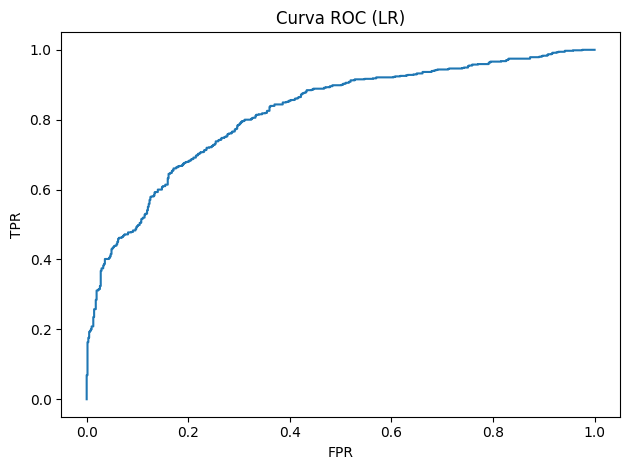

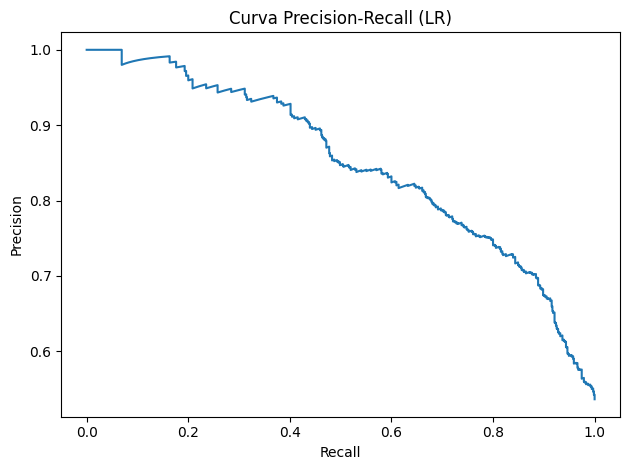

In [8]:
# === 8) Curvas ROC y PR (LR) ===
import matplotlib.pyplot as plt

train_summary = lr_model.summary
roc_df = train_summary.roc.toPandas()
pr_df = train_summary.pr.toPandas()

# ROC
plt.figure()
plt.plot(roc_df['FPR'], roc_df['TPR'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC (LR)')
plt.tight_layout()
plt.show()

# PR
plt.figure()
plt.plot(pr_df['recall'], pr_df['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (LR)')
plt.tight_layout()
plt.show()

## Matriz de confusión (RF)

Convertimos a pandas para graficar.


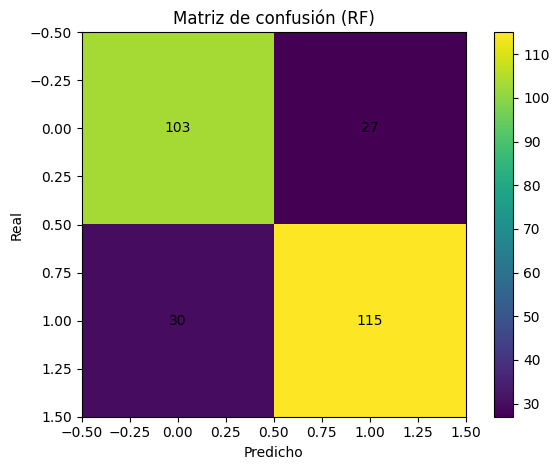

In [9]:
# === 9) Matriz de confusión (RF) ===
from sklearn.metrics import confusion_matrix
import numpy as np

preds_rf = pred_rf.select('prediction', 'label').toPandas()
cm = confusion_matrix(preds_rf['label'], preds_rf['prediction'])

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de confusión (RF)')
plt.xlabel('Predicho')
plt.ylabel('Real')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()

## Importancia de variables (RF)


In [10]:
# === 10) Importancia de variables (RF) ===
import pandas as pd
fi = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.featureImportances.toArray()
}).sort_values('importance', ascending=False)

fi.head(10)

,feature,importance
10,alcohol,0.374190
9,sulphates,0.163079
1,volatile acidity,0.140150
6,total sulfur dioxide,0.091290
7,density,0.058271
0,fixed acidity,0.037808
4,chlorides,0.033634
8,pH,0.031425
2,citric acid,0.027230
5,free sulfur dioxide,0.024238


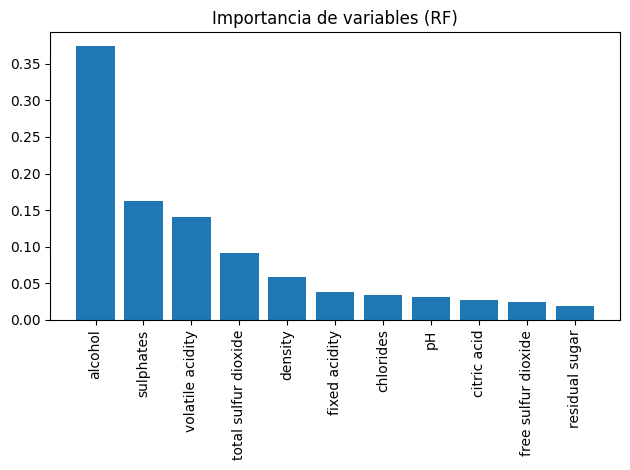

In [11]:
# Gráfico de importancia (una figura, sin estilos de color específicos)
import matplotlib.pyplot as plt

plt.figure()
plt.bar(fi['feature'], fi['importance'])
plt.xticks(rotation=90)
plt.title('Importancia de variables (RF)')
plt.tight_layout()
plt.show()

## Búsqueda de hiperparámetros + CrossValidator (RF)


In [12]:
# === 11) Cross-Validation (RF) ===
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [100, 200, 400])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol='label'),
    numFolds=3,
    parallelism=2
)

cv_model = cv.fit(train)
cv_pred = cv_model.bestModel.transform(test)
auc_cv = evaluator.evaluate(cv_pred)

print("AUC RF (CV):", auc_cv)
cv_model.bestModel

AUC RF (CV): 0.8832360742705573


RandomForestClassificationModel: uid=RandomForestClassifier_d6b98bcbb4be, numTrees=400, numClasses=2, numFeatures=11

## Comparativa de modelos
Calcula métricas (Accuracy, Precision, Recall, F1) y compáralas.


In [13]:
# === 12) Comparativa de métricas ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics_from_spark_pred(spark_pred_df):
    pdf_pred = spark_pred_df.select('label', 'prediction').toPandas()
    acc = accuracy_score(pdf_pred['label'], pdf_pred['prediction'])
    pre = precision_score(pdf_pred['label'], pdf_pred['prediction'])
    rec = recall_score(pdf_pred['label'], pdf_pred['prediction'])
    f1  = f1_score(pdf_pred['label'], pdf_pred['prediction'])
    return acc, pre, rec, f1

acc_lr, pre_lr, rec_lr, f1_lr = metrics_from_spark_pred(pred_lr)
acc_rf, pre_rf, rec_rf, f1_rf = metrics_from_spark_pred(pred_rf)
acc_cv, pre_cv, rec_cv, f1_cv = metrics_from_spark_pred(cv_pred)

import pandas as pd
summary = pd.DataFrame({
    'modelo': ['LR', 'RF', 'RF (CV)'],
    'AUC':    [auc_lr, auc_rf, auc_cv],
    'Accuracy': [acc_lr, acc_rf, acc_cv],
    'Precision': [pre_lr, pre_rf, pre_cv],
    'Recall': [rec_lr, rec_rf, rec_cv],
    'F1': [f1_lr, f1_rf, f1_cv]
})
summary

,modelo,AUC,Accuracy,Precision,Recall,F1
0,LR,0.835066,0.774545,0.812030,0.744828,0.776978
1,RF,0.854907,0.792727,0.809859,0.793103,0.801394
2,RF (CV),0.883236,0.818182,0.827586,0.827586,0.827586


## Conclusiones
- Compara resultados y justifica el modelo recomendado.
- Discute *trade-offs* (complejidad, interpretabilidad, rendimiento).
- (Opcional) Propuestas de mejora: balanceo de clases, más features, MLflow, explicabilidad.
